In [2]:
import json
import torch
import numpy as np
import torch.nn as nn
from TorchCRF import CRF
import torch.optim as optim
import gensim.downloader as gensim_api


word2vec = gensim_api.load("word2vec-google-news-300")
glove = gensim_api.load("glove-wiki-gigaword-300")
fasttext = gensim_api.load("fasttext-wiki-news-subwords-300")

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Loading Dataset (Json)

In [4]:
with open('../data/ATE_Train.json','r') as f:
    train_json = json.load(f)
with open('../data/ATE_Val.json','r') as f:
    val_json = json.load(f)
with open('../data/ATE_Test.json','r') as f:
    test_json = json.load(f)

In [5]:
def get_embeddings(text, embeddings):
    words = text.split()
    embeddings_list = [embeddings[word] if word in embeddings else np.zeros(embeddings.vector_size) for word in words]
    return torch.tensor(embeddings_list, dtype=torch.float32)

# Convert JSON dataset to numerical format
def get_dataset(word_embedding, json_file, label_mapping):
    numerical_dataset = []
    for key, example in json_file.items():
        text_embeddings = get_embeddings(example["text"], word_embedding)
        label_sequence = torch.tensor([label_mapping[label] for label in example["labels"]], dtype=torch.float32)
        numerical_dataset.append((text_embeddings, label_sequence))
    return numerical_dataset

In [6]:
label_mapping = {"B": 0, "I": 1, "O": 2}
word2vec_train_embeddings = get_dataset(word_embedding=word2vec, json_file=train_json, label_mapping=label_mapping)
word2vec_val_embeddings = get_dataset(word_embedding=word2vec, json_file=val_json, label_mapping=label_mapping)
word2vec_test_embeddings = get_dataset(word_embedding=word2vec, json_file=test_json, label_mapping=label_mapping)

glove_train_embeddings = get_dataset(word_embedding=glove, json_file=train_json, label_mapping=label_mapping)
glove_val_embeddings = get_dataset(word_embedding=glove, json_file=val_json, label_mapping=label_mapping)
glove_test_embeddings = get_dataset(word_embedding=glove, json_file=test_json, label_mapping=label_mapping)

fasttext_train_embeddings = get_dataset(word_embedding=fasttext, json_file=train_json, label_mapping=label_mapping)
fasttext_val_embeddings = get_dataset(word_embedding=fasttext, json_file=val_json, label_mapping=label_mapping)
fasttext_test_embeddings = get_dataset(word_embedding=fasttext, json_file=test_json, label_mapping=label_mapping)

### Model (BiLSTM)

In [7]:
class BiLSTMCRF(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiLSTMCRF, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, output_size)
        self.crf = CRF(output_size)

    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state for bidirectional LSTM
        c0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)  # Initialize cell state for bidirectional LSTM
        out, _ = self.lstm(x, (h0, c0))  # Forward propagate bidirectional LSTM
        out = self.fc(out)
        return out

    def neg_log_likelihood(self, x, tags):
        out = self.forward(x)
        return -self.crf(out, tags)

    def decode(self, x):
        out = self.forward(x)
        return self.crf.decode(out)



### Train and loss functions

In [13]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

def train_model(model, train_data, val_data, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        predictions_train = []
        true_labels_train = []

        for inputs, labels in train_data:
            optimizer.zero_grad()
            inputs = inputs.unsqueeze(0)
            outputs = model(inputs)
            outputs = outputs.to(torch.float)
            labels = torch.tensor(labels, dtype=torch.long)
            loss = criterion(outputs.view(-1, output_size), labels)
            loss.backward()
            optimizer.step()

            # Keep track of training set predictions and true labels
            _, predicted_train = torch.max(outputs, 2)
            predictions_train.extend(predicted_train.view(-1).cpu().numpy())
            true_labels_train.extend(labels.view(-1).cpu().numpy())

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        predictions = []
        true_labels = []

        with torch.no_grad():
            for inputs, labels in val_data:
                inputs = inputs.unsqueeze(0)
                outputs = model(inputs)
                labels = torch.tensor(labels, dtype=torch.long)
                val_loss += criterion(outputs.view(-1, output_size), labels)
                _, predicted = torch.max(outputs, 2)
                predictions.extend(predicted.view(-1).cpu().numpy())
                true_labels.extend(labels.view(-1).cpu().numpy())

        val_loss /= len(val_data)
        train_losses.append(train_loss / len(train_data))
        val_losses.append(val_loss)

        # Calculate F1 scores
        train_f1 = f1_score(true_labels_train, predictions_train, average='macro')
        val_f1 = f1_score(true_labels, predictions, average='macro')
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}, Train Loss: {train_loss / len(train_data):.4f}, Train F1 Score: {train_f1:.4f}.....')

    # Function to plot loss
    def plot_loss(train_losses, val_losses):
        plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
        plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

    # Function to plot F1 score
    def plot_f1_score(train_f1_scores, val_f1_scores):
        plt.plot(range(1, len(train_f1_scores) + 1), train_f1_scores, label='Training F1 Score')
        plt.plot(range(1, len(val_f1_scores) + 1), val_f1_scores, label='Validation F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.title('Training and Validation F1 Score')
        plt.legend()
        plt.show()
    plot_loss(train_losses, val_losses)
    plot_f1_score(train_f1_scores, val_f1_scores)


### Testing 

In [14]:
def calculate_f1_score(model, test_loader):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(0)
            outputs = model(inputs)
            labels = torch.tensor(labels, dtype=torch.long)
            _, predicted = torch.max(outputs, 2)
            predictions.extend(predicted.view(-1).cpu().numpy())
            true_labels.extend(labels.view(-1).cpu().numpy())
    test_f1 = f1_score(true_labels, predictions, average='macro')
    return test_f1

### Model Training and Evaluation using Word2Vec Embeddings ###


Training BiLSTM-CRF model with word2vec embeddings:
Epoch 1/10, Validation Loss: 0.1606, Validation F1 Score: 0.7532, Train Loss: 0.2641, Train F1 Score: 0.6445.....
Epoch 2/10, Validation Loss: 0.1444, Validation F1 Score: 0.7883, Train Loss: 0.1485, Train F1 Score: 0.7979.....
Epoch 3/10, Validation Loss: 0.1440, Validation F1 Score: 0.7969, Train Loss: 0.1083, Train F1 Score: 0.8495.....
Epoch 4/10, Validation Loss: 0.1517, Validation F1 Score: 0.8032, Train Loss: 0.0754, Train F1 Score: 0.8959.....
Epoch 5/10, Validation Loss: 0.1611, Validation F1 Score: 0.8031, Train Loss: 0.0508, Train F1 Score: 0.9267.....
Epoch 6/10, Validation Loss: 0.1714, Validation F1 Score: 0.8208, Train Loss: 0.0362, Train F1 Score: 0.9499.....
Epoch 7/10, Validation Loss: 0.1867, Validation F1 Score: 0.8123, Train Loss: 0.0217, Train F1 Score: 0.9746.....
Epoch 8/10, Validation Loss: 0.2156, Validation F1 Score: 0.7912, Train Loss: 0.0178, Train F1 Score: 0.9771.....
Epoch 9/10, Validation Loss: 0.2018

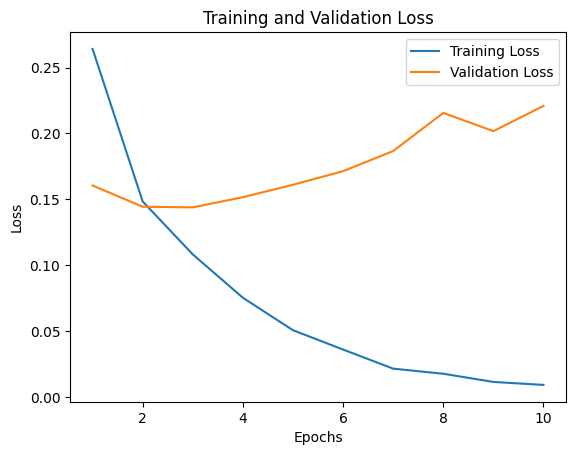

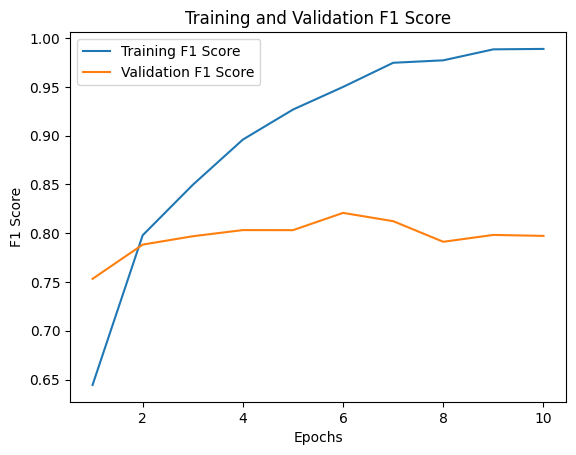

BiLSTM Model Testing using word2vec embeddings (Test F1 Score): 0.7790


In [15]:
# Hyperparameters
input_size = 300
hidden_size = 128
output_size = 3  # Number of classes (BIO tags)
learning_rate = 0.001
num_epochs = 10


print(f'\nTraining BiLSTM-CRF model with word2vec embeddings:')
model = BiLSTMCRF(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_model(model, word2vec_train_embeddings, word2vec_val_embeddings, criterion, optimizer, num_epochs)

# Calculate and print the test F1 score
test_f1_score = calculate_f1_score(model, word2vec_test_embeddings)
print(f'BiLSTM Model Testing using word2vec embeddings (Test F1 Score): {test_f1_score:.4f}')

# Save the trained model
torch.save(model.state_dict(), f'BiLSTM_word2vec_model.pth')

### Model Training and Evaluation using Glove Embeddings ###


Training BiLSTM-CRF model with glove embeddings:
Epoch 1/10, Validation Loss: 0.1857, Validation F1 Score: 0.7197, Train Loss: 0.2714, Train F1 Score: 0.6219.....
Epoch 2/10, Validation Loss: 0.1674, Validation F1 Score: 0.7523, Train Loss: 0.1711, Train F1 Score: 0.7603.....
Epoch 3/10, Validation Loss: 0.1759, Validation F1 Score: 0.7557, Train Loss: 0.1164, Train F1 Score: 0.8381.....
Epoch 4/10, Validation Loss: 0.1900, Validation F1 Score: 0.7710, Train Loss: 0.0746, Train F1 Score: 0.9061.....
Epoch 5/10, Validation Loss: 0.1953, Validation F1 Score: 0.7773, Train Loss: 0.0473, Train F1 Score: 0.9422.....
Epoch 6/10, Validation Loss: 0.2309, Validation F1 Score: 0.7630, Train Loss: 0.0311, Train F1 Score: 0.9677.....
Epoch 7/10, Validation Loss: 0.2265, Validation F1 Score: 0.7697, Train Loss: 0.0230, Train F1 Score: 0.9740.....
Epoch 8/10, Validation Loss: 0.2539, Validation F1 Score: 0.7710, Train Loss: 0.0183, Train F1 Score: 0.9774.....
Epoch 9/10, Validation Loss: 0.2469, V

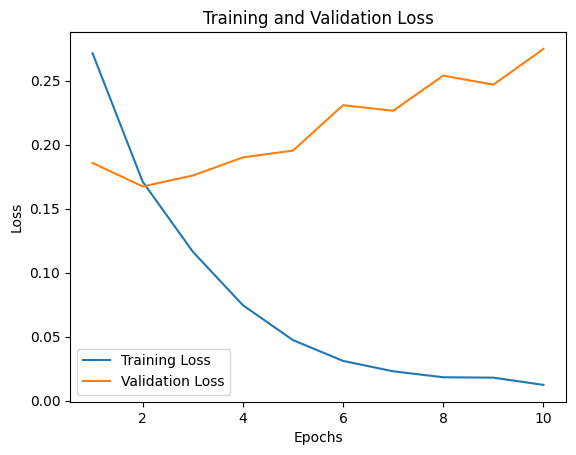

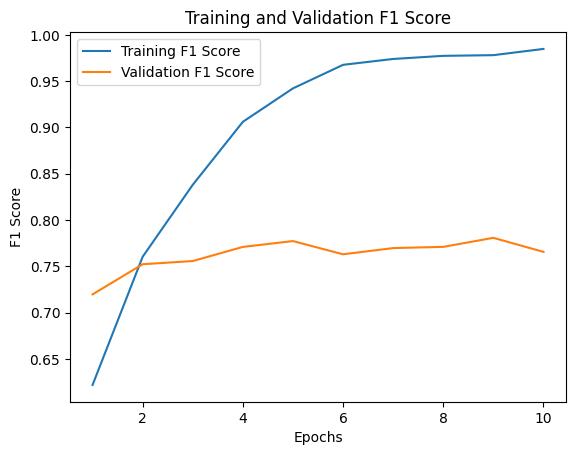

BiLSTM Model Testing using glove embeddings (Test F1 Score): 0.7312


In [16]:
# Hyperparameters
input_size = 300
hidden_size = 128
output_size = 3  # Number of classes (BIO tags)
learning_rate = 0.001
num_epochs = 10


print(f'\nTraining BiLSTM-CRF model with glove embeddings:')
model = BiLSTMCRF(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_model(model, glove_train_embeddings, glove_val_embeddings, criterion, optimizer, num_epochs)

# Calculate and print the test F1 score
test_f1_score = calculate_f1_score(model, glove_test_embeddings)
print(f'BiLSTM Model Testing using glove embeddings (Test F1 Score): {test_f1_score:.4f}')

# Save the trained model
torch.save(model.state_dict(), f'bilstm_glove_model.pth')

### Model Training and Evaluation using fasttext Embeddings ###


Training BiLSTM-CRF model with fasttext embeddings:
Epoch 1/10, Validation Loss: 0.1610, Validation F1 Score: 0.7409, Train Loss: 0.2732, Train F1 Score: 0.5987.....
Epoch 2/10, Validation Loss: 0.1416, Validation F1 Score: 0.7733, Train Loss: 0.1637, Train F1 Score: 0.7639.....
Epoch 3/10, Validation Loss: 0.1354, Validation F1 Score: 0.7876, Train Loss: 0.1353, Train F1 Score: 0.8080.....
Epoch 4/10, Validation Loss: 0.1406, Validation F1 Score: 0.7976, Train Loss: 0.1115, Train F1 Score: 0.8456.....
Epoch 5/10, Validation Loss: 0.1531, Validation F1 Score: 0.7866, Train Loss: 0.0909, Train F1 Score: 0.8724.....
Epoch 6/10, Validation Loss: 0.1460, Validation F1 Score: 0.7809, Train Loss: 0.0754, Train F1 Score: 0.8950.....
Epoch 7/10, Validation Loss: 0.1645, Validation F1 Score: 0.7935, Train Loss: 0.0601, Train F1 Score: 0.9173.....
Epoch 8/10, Validation Loss: 0.1811, Validation F1 Score: 0.7805, Train Loss: 0.0437, Train F1 Score: 0.9399.....
Epoch 9/10, Validation Loss: 0.1826

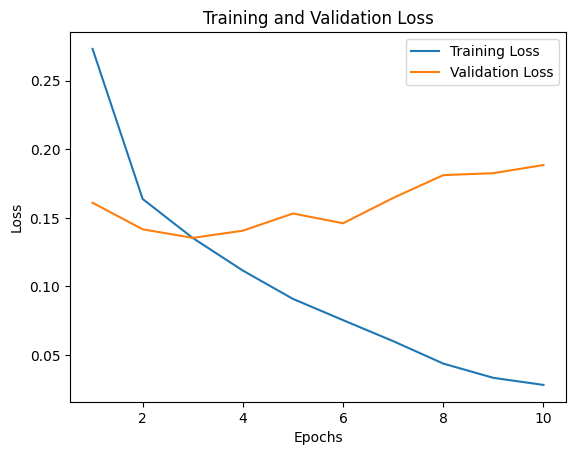

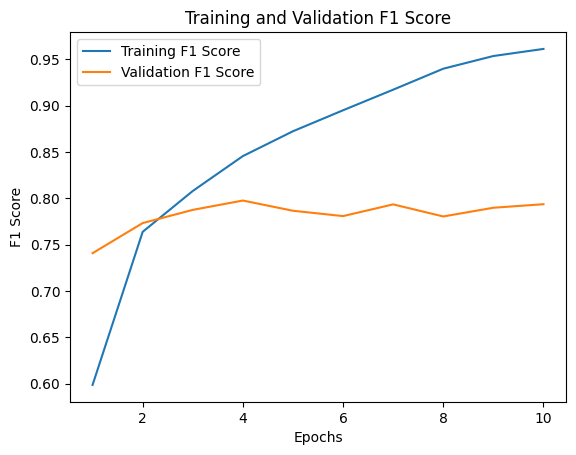

BiLSTM Model Testing using fasttext embeddings (Test F1 Score): 0.7879


In [17]:
# Hyperparameters
input_size = 300
hidden_size = 128
output_size = 3  # Number of classes (BIO tags)
learning_rate = 0.001
num_epochs = 10


print(f'\nTraining BiLSTM-CRF model with fasttext embeddings:')
model = BiLSTMCRF(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_model(model, fasttext_train_embeddings, fasttext_val_embeddings, criterion, optimizer, num_epochs)

# Calculate and print the test F1 score
test_f1_score = calculate_f1_score(model, fasttext_test_embeddings)
print(f'BiLSTM Model Testing using fasttext embeddings (Test F1 Score): {test_f1_score:.4f}')

# Save the trained model
torch.save(model.state_dict(), f'bilstm_fasttext_model.pth')